In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

from sklearn.decomposition import PCA

from maskrcnn.preprocess.sample_aoi import load_df
from maskrcnn.postprocess.validate import transform_coord, plot_scatter

import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [2]:
# input path
# image index data
IDX_IN_DIR = 'data/Experiment0/aoi.csv'
# download log data
LOG_IN_DIR = 'data/Experiment0/aoi_download_log.csv'

SAT_IN_DIR = 'data/Nightlight/VIIRS_DNB_MX_2018.tif'
FULL_CEN_IN_DIR = 'data/CPV/Raw/ITER2010/ITER_NALDBF10.csv'
CEN_IN_DIR = 'data/Experiment0/census.csv'
# output path
OUT_DIR = 'data/Experiment0/Output/'

In [3]:
# renamed columns in census, translate to English
CEN_COLS = {
    'POBTOT': 'cen_pop',
    # 'VIVTOT': 'cen_house',  # duplicate-ish
    # 'TVIVHAB': 'cen_inhab',  # duplicate-ish
    'cen_asset_score_pca': 'cen_asset_score_pca',
    'cen_public_score_pca': 'cen_public_score_pca',
    'cen_durable_score_pca': 'cen_durable_score_pca',
    'cen_housing_score_pca': 'cen_housing_score_pca',
    # 'cen_asset_score_sum': 'cen_asset_score_sum',  # results very similar to PCA
    # 'VPH_SNBIEN': 'cen_nodurable',  # meh
    # 'VPH_1CUART': 'cen_1room',  # no signal
    'VPH_3YMASC': 'cen_3plusroom',
    'VPH_REFRI': 'cen_refri',
    'VPH_AUTOM': 'cen_autom',
    'VPH_C_ELEC': 'cen_elec',
    'VPH_PISODT': 'cen_floor',
    # 'VPH_AGUADV': 'cen_water',  # meh
    # 'VPH_EXCSA': 'cen_toilet',  # meh
    # 'VPH_DRENAJ': 'cen_drainage',  # meh
    # 'VPH_INTER': 'cen_internet'  # no signal
}

In [4]:
dataset = rasterio.open(SAT_IN_DIR)
band = dataset.read(1)

## Same Sample as Our Approach

In [5]:
# read image index data frame
df_idx = pd.merge(pd.read_csv(IDX_IN_DIR), pd.read_csv(LOG_IN_DIR),
                  how='outer', on='index')
df_idx = df_idx.loc[:, ['index', 'ent', 'mun', 'loc', 'chip',
                        'status', 'lon_min', 'lon_max', 'lat_min', 'lat_max']]

In [6]:
# read census data
df = pd.read_csv(CEN_IN_DIR)

# drop NA localities with no images
df = pd.merge(
    df,
    df_idx.groupby(['ent', 'mun', 'loc']).agg(
        no_missing=pd.NamedAgg(column='status',
                               aggfunc=lambda x: sum(pd.isna(x)))),
    how='outer',
    on=['ent', 'mun', 'loc'])
df = df.loc[df['no_missing'] == 0, :]

In [7]:
db_cols = ['VPH_RADIO', 'VPH_TV', 'VPH_REFRI', 'VPH_LAVAD',
           'VPH_AUTOM', 'VPH_PC', 'VPH_TELEF', 'VPH_CEL', 'VPH_INTER']
housing_cols = ['VPH_PISODT', 'VPH_2YMASD', 'VPH_3YMASC']
public_cols = ['VPH_C_ELEC', 'VPH_AGUADV', 'VPH_EXCSA', 'VPH_DRENAJ']
vph_cols = db_cols + housing_cols + public_cols  # all

for cols, output_col in zip([db_cols, housing_cols, public_cols, vph_cols],
                            ['cen_durable_score_pca', 'cen_housing_score_pca',
                             'cen_public_score_pca', 'cen_asset_score_pca']):
    # compute asset score via pca
    centered = (df.loc[:, cols].values -
                df.loc[:, cols].values.mean(axis=0)[np.newaxis, :])
    m = PCA(n_components=1)
    df.loc[:, output_col] = m.fit_transform(centered)

# # compute asset score via summing
# df.loc[:, 'cen_asset_score_sum'] = df.loc[:, vph_cols].sum(axis=1)

df['cen_housing_score_pca'] *= -1
df['cen_public_score_pca'] *= -1

In [8]:
# rename and select columns
df = (df.loc[:, ['ent', 'mun', 'loc', 'sample', 'lon', 'lat'] + list(CEN_COLS.keys())]
        .rename(columns=CEN_COLS))

In [9]:
idx = np.round(transform_coord(
    transform=dataset.transform,
    to='colrow',
    xy=df.loc[:, ['lon', 'lat']].values)).astype(np.int)

df['sat_nightlight'] = [band[i[1], i[0]] for i in idx]

In [10]:
# drop outliers
df = df.loc[df['sat_nightlight'] <= df['sat_nightlight'].quantile(q=0.985), :]

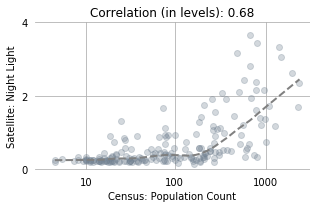

In [11]:
plot_scatter(
    col_x_key='cen_pop',
    col_x_label='Census: Population Count',
    transform_x=lambda x: np.log10(x + 1),
    xlim=(np.log10(3), np.log10(3000)),
    xticks=[np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    xticklabels=[10, 100, 1000],
    col_y_key='sat_nightlight',
    col_y_label='Satellite: Night Light',
    ylim=(-0.01, 4),
    yticks=[0, 2, 4],
    alpha=0.3, line=True, df=df,
    out_dir=OUT_DIR,
    show=True)

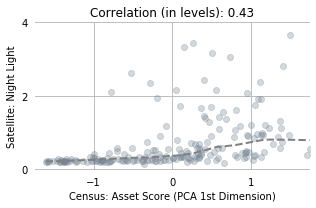

In [12]:
plot_scatter(
    col_x_key='cen_asset_score_pca',
    col_x_label='Census: Asset Score (PCA 1st Dimension)',
    xlim=(-1.75, 1.75),
    xticks=[-1, 0, 1],
    col_y_key='sat_nightlight',
    col_y_label='Satellite: Night Light',
    ylim=(-0.01, 4),
    yticks=[0, 2, 4],
    alpha=0.3,
    line=True, df=df, out_dir=OUT_DIR, show=True)

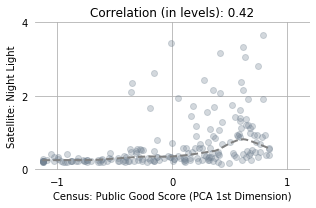

In [13]:
plot_scatter(
    col_x_key='cen_public_score_pca',
    col_x_label='Census: Public Good Score (PCA 1st Dimension)',
    xlim=(-1.2, 1.2),
    xticks=[-1, 0, 1],
    col_y_key='sat_nightlight',
    col_y_label='Satellite: Night Light',
    ylim=(-0.01, 4),
    yticks=[0, 2, 4],
    alpha=0.3,
    line=True, df=df, out_dir=OUT_DIR, show=True)

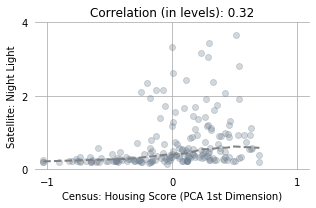

In [14]:
plot_scatter(
    col_x_key='cen_housing_score_pca',
    col_x_label='Census: Housing Score (PCA 1st Dimension)',
    xlim=(-1.1, 1.1),
    xticks=[-1, 0, 1],
    col_y_key='sat_nightlight',
    col_y_label='Satellite: Night Light',
    ylim=(-0.01, 4),
    yticks=[0, 2, 4],
    alpha=0.3,
    line=True, df=df, out_dir=OUT_DIR, show=True)

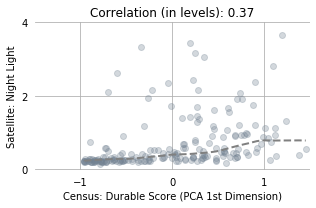

In [15]:
plot_scatter(
    col_x_key='cen_durable_score_pca',
    col_x_label='Census: Durable Score (PCA 1st Dimension)',
    xlim=(-1.5, 1.5),
    xticks=[-1, 0, 1],
    col_y_key='sat_nightlight',
    col_y_label='Satellite: Night Light',
    ylim=(-0.01, 4),
    yticks=[0, 2, 4],
    alpha=0.3,
    line=True, df=df, out_dir=OUT_DIR, show=True)

## Full Sample

In [16]:
df = load_df(FULL_CEN_IN_DIR, drop=False)

df = df.sample(n=200, random_state=1, weights='POBTOT')

idx = np.round(transform_coord(
    transform=dataset.transform,
    to='colrow',
    xy=df.loc[:, ['lon', 'lat']].values)).astype(np.int)

df['nightlight'] = [band[i[1], i[0]] for i in idx]

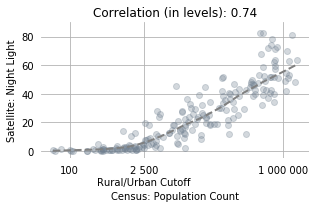

In [17]:
plot_scatter(
    col_x_key='POBTOT',
    col_x_label='Census: Population Count',
    transform_x=lambda x: np.log10(x + 1),
    xticks=[np.log10(1e2 + 1), np.log10(2.5e3 + 1), np.log10(1e6 + 1)],
    xticklabels=['100', '2 500\nRural/Urban Cutoff', '1 000 000'],
    col_y_key='nightlight',
    col_y_label='Satellite: Night Light',
    ylim=(-5, 90),
    alpha=0.3, line=True, df=df, out_dir=OUT_DIR, show=True)